In [30]:
import os
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer 
import io
import math

import google_auth_oauthlib.flow
import googleapiclient.discovery
import googleapiclient.errors
from pymystem3 import Mystem
from string import punctuation
import pymorphy2
from urllib.error import HTTPError
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

## Получение списка видео для заданного канала (Developer_key удален в целях безопасности)

In [2]:
def videos_list(channel_id):
    os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"

    api_service_name = "youtube"
    api_version = "v3"
    DEVELOPER_KEY = ""

    youtube = googleapiclient.discovery.build(
        api_service_name, api_version, developerKey = DEVELOPER_KEY)

    request = youtube.search().list(
        part="id",
        channelId=channel_id,
        order="date",
        maxResults=40
    )
    response = request.execute()

    return response

## Получение списка комментариев и ответов на комментарии для заданного видео

In [3]:
def comments_list(video_id):
    os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"

    api_service_name = "youtube"
    api_version = "v3"
    DEVELOPER_KEY = ""

    youtube = googleapiclient.discovery.build(
        api_service_name, api_version, developerKey = DEVELOPER_KEY)
     
    comments = list()
    
    nextIterationFlag = True
    nextPageToken=""
    while nextIterationFlag:
        video_response = dict()
        try:
            video_response=youtube.commentThreads().list( 
            part='snippet,replies', 
            videoId=video_id,
            pageToken=nextPageToken).execute()
        
            for item in video_response['items']: 
            
                # Получает текст комментария
                comment = item['snippet']['topLevelComment']['snippet']['textDisplay'].replace('<br />','').replace('\xa0',' ')
                comments.append(comment)
            
                # Проверяем, есть ли ответы на комментарии
                replycount = item['snippet']['totalReplyCount']    
                # Если ответы есть, то добавляем ответы
                if replycount>0: 
                    for reply in item['replies']['comments']: 
                         comments.append(reply['snippet']['textDisplay'].replace('<br />','').replace('\xa0',' ')) 
        except:
            print('Для видео '+video_id+' комментарии пользователей скрыты')
            return(list())
            # Если необходимо перейти на следующую страницу комментариев, то переходим
        nextIterationFlag ='nextPageToken' in video_response
        if nextIterationFlag:
            nextPageToken = video_response['nextPageToken']
    return comments

## Построение частотных словарей на основе стемминга и лемматизации

In [4]:
def CreateStemmingFrequencyDict(comments, fileOutputName):
    
    words = list()
    for comment in comments:
        words += nltk.word_tokenize(comment)
    stopWordsArray = stopwords.words("russian")
    stemmingFrequencyDict = {}
    stemmer = SnowballStemmer("russian")
    punctuationList = punctuation+'«»—„“–&'
    
    for i in range(len(words)):
        oldWord = words[i].lower()
        if not (oldWord == " " or oldWord.startswith("...") or oldWord.strip() in punctuationList):
            newWord = stemmer.stem(words[i].lower())
            if not (newWord in stopWordsArray):
                if (newWord in stemmingFrequencyDict):
                    stemmingFrequencyDict[newWord]+=1
                else:
                    stemmingFrequencyDict[newWord]=1
                    
    with open(fileOutputName, "w", errors='ignore', encoding='ANSI') as file:
        for k in sorted(stemmingFrequencyDict, key=stemmingFrequencyDict.get, reverse=True):
            file.write(k + ";" + str(stemmingFrequencyDict[k])+"\n")
            
    return stemmingFrequencyDict

In [5]:
def CreateLemmatisationFrequencyDict(comments, fileOutputName):
    
    words = list()
    for comment in comments:
        words += nltk.word_tokenize(comment)
    stopWordsArray = stopwords.words("russian")
    frequencyDict = {}
    morph = pymorphy2.MorphAnalyzer()
    punctuationList = punctuation+'«»—„“–'
    
    for i in range(len(words)):
        oldWord = words[i].lower()
        if not (oldWord == " " or oldWord == "..." or oldWord.strip() in punctuationList):
            newWord = morph.parse(oldWord)[0].normal_form
            if not (newWord in stopWordsArray):
                if (newWord in frequencyDict):
                    frequencyDict[newWord]+=1
                else:
                    frequencyDict[newWord]=1
    
    with open(fileOutputName, "w", errors='ignore', encoding='ANSI') as file:
        for k in sorted(frequencyDict, key=frequencyDict.get, reverse=True):
            file.write(k + ";" + str(frequencyDict[k])+"\n")
            
    return frequencyDict

### Получаем видео для канала

In [6]:
videos = videos_list("UC193uGXxnLINZQm_Zf_rV6w")['items']

### Получаем ИД всех видео

In [7]:
video_ids = list()
for video in videos:
    if 'videoId' in video['id']:
        video_ids.append(video['id']['videoId'])

In [8]:
video_ids

['vYyE2z8MjpM',
 'igd9ii0vQfM',
 'i17PVbExIuE',
 'vfPVPBFEgE8',
 'iSBEvM3jExM',
 'Z2uEjjBcbD8',
 'D7wA_TQB2uM',
 'asg0aNEeqdI',
 'ZEjhw6nPMyE',
 '82rRiPHaMpA',
 's_bllxM1-CI',
 'M-WKOqTREJU',
 'UnKSgok3_pk',
 'TnGFVgiLDVg',
 'fnWParzTmME',
 '-hOJx2SuBvM',
 '7tUymJPqQXo',
 'qZC7Rz253ag',
 'iK_hVJXdpJ0',
 'f5C0j2i7MtM',
 'UlzXkymi_Yo',
 'ZldsInV_yH4',
 'E68RZSRcJro',
 'y9ESjw1y18o',
 'rg7CG8XKEPY',
 'HnDu_94pKl4',
 'WfpoxdrtmeY',
 'c1YQUXmfRqE',
 'MaWEGcPTl4Q',
 'nQEP3njOs04',
 '0DBLHrH2W_Q',
 'sI9gRZrwwLQ',
 '0oCY70d8sEM',
 'mZD2UQ9KKfw',
 'QE1A82UvSj0',
 'ODegdZj8xcc',
 'x0gKtsfpKF0',
 '9yiDRBiOsA0']

### Для каждого видео собираем все комментарии

In [9]:
comments = list()
for video_id in video_ids:
    comments += comments_list(video_id)

Для видео E68RZSRcJro комментарии пользователей скрыты


In [10]:
comments

['Чеза красота',
 'Чувак, я не пойму, ты из прошлого века передовых технологий? Не снимай в 5/4 соотношение экрана, не приятно смотреть.Если хочешь делать видео от которых сучки текли. Сделай видео что-бы было не уныло, а интересно, даже с одним модом. Напиши текст. На интро забей, оно не особо нужно в moviemaker&#39;стве.',
 'А ну да, 720P это уже настолько СИЛЬНО ГРУЗИТ комп, ахуеть.Если в сборке уже 250 модов....',
 'Всем кто хочет получить пиратку без угрозы для компа может смело использовать сайт HackPhenix я на нем не только АТЛ скачал но ФТБ все работает и обновляеться спасибо автору за видео!!!\\',
 'Сначало не поверил но почитав коменты начал ещё больше сомневаться в том что вирус но я проверил его на сайте ВИРУС ТОТАЛ (ЭТО НЕ РЕКЛАМА) скачал и только этот лаунчер работал хотя качал сотню таких же других',
 'спасибо играю в твой сборку и Yogast не вылетает и не лагает',
 'ее братан помог спасибо)',
 'какого фига ты это снимаеш',
 'Это вирус! не поподайтесь на это!!!',
 'БРО ЧЁ

### Составляем и сохраняем в формате CSV частотные словари

In [11]:
frequencyDict = CreateStemmingFrequencyDict(comments, "Частотный словарь комментариев.csv")

In [12]:
for k in sorted(frequencyDict, key=frequencyDict.get, reverse=True):
    print(k + " " + str(frequencyDict[k]))

сборк 161
мен 133
эт 125
мод 119
теб 69
сервер 64
скача 59
виде 53
спасиб 53
есл 53
верс 49
лайк 49
ест 47
прост 47
игра 44
крут 38
мо 37
чувак 36
снима 35
дела 34
работа 34
че 34
спс 34
ил 34
можн 33
скайп 32
ег 30
плиз 29
quot 29
скин 28
когд 28
ссылк 27
пишет 27
ещ 26
друг 26
норм 26
комп 25
зборк 25
ip 25
тво 24
помог 24
мог 24
майн 24
кача 23
пот 23
поч 23
клиент 23
5 22
установ 22
скаж 22
тольк 21
сдела 20
лага 20
сво 20
тоб 20
игр 20
2 20
мир 20
напиш 19
3 19
читер 19
подписк 19
хот 17
поигра 17
участв 17
пиратк 16
'' 16
нужн 15
больш 15
е 15
файл 15
хорош 15
лаунчер 14
мног 14
бля 14
школьник 14
очен 14
парол 14
серв 14
сказа 14
пожалуйст 14
час 14
1 13
d 13
сто 13
нег 13
лиценз 13
зна 13
себ 13
тож 13
ток 13
котор 12
ник 12
туп 12
майнкрафт 12
голос 12
скачива 12
класс 12
описан 12
написа 11
паца 11
хлопн 11
айфон 11
вмест 11
крафт 11
найт 11
кана 11
зайт 11
яндекс 11
минут 11
добав 11
слуша 11
люд 11
писа 11
блин 11
нормальн 11
даж 10
идет 10
постав 10
подушк 10
ок 10
удал 10

In [13]:
frequencyLemmaDict = CreateLemmatisationFrequencyDict(comments, "Частотный словарь комментариев 2.csv")

In [14]:
for k in sorted(frequencyLemmaDict, key=frequencyLemmaDict.get, reverse=True):
    print(k + " " + str(frequencyLemmaDict[k]))

сборка 161
это 99
мода 69
всё 64
сервер 64
скачать 55
видео 52
писать 52
спасибо 50
версия 49
мочь 48
мод 45
лайк 45
просто 45
играть 44
чувак 36
сказать 36
снимать 35
работать 34
спс 34
делать 33
скайп 32
написать 29
помочь 29
плиз 29
quot 29
ссылка 27
норма 26
комп 25
ещё 25
скинуть 25
ip 25
твой 24
зборк 24
майн 24
крутой 23
почему 23
знать 23
клиент 23
5 22
найти 22
установить 21
сделать 20
дать 20
игра 20
2 20
мир 20
3 19
свой 19
читер 19
подписка 19
че 19
лагаета 17
поиграть 17
участвовать 17
пиратка 16
идти 16
круто 16
'' 16
зайти 16
человек 16
хотеть 15
качать 15
файл 15
ставить 15
бля 14
школьник 14
очень 14
пароль 14
хороший 14
час 14
лаунчер 13
поставить 13
1 13
d 13
смотреть 13
лицензия 13
нужный 13
пожалуйста 13
который 12
большой 12
пацан 12
майнкрафт 12
стоить 12
голос 12
канал 12
класс 12
добавить 12
описание 12
ник 11
хлопнуть 11
айфон 11
друг 11
яндекс 11
минута 11
слушать 11
её 11
блин 11
уметь 11
весь 10
подушка 10
заходить 10
около 10
тупой 10
удалить 10
супер 10
в

## Составляем облако слов по частотному словарю, основанному на лемматизации

In [46]:
wordcloud = WordCloud(background_color="white", max_words=100, max_font_size=50).generate_from_frequencies(frequencies=frequencyLemmaDict)

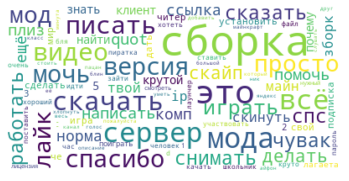

In [47]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()